In [3]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


# Original Network

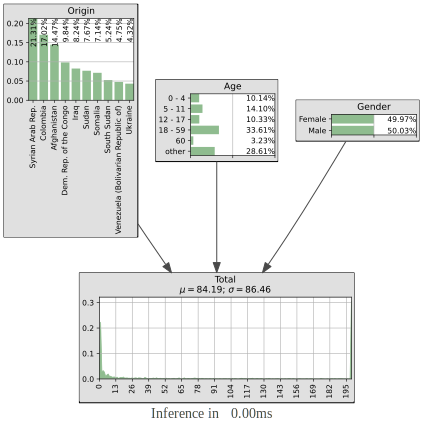

In [2]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
#df2 = df2[df2.Total >= 1000000]
countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]
genderLabel = ["Female", "Male"]
model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))

maxRange = 500

nodeList = ["Total"]
rangeNode = {"Total": 200
            }

coeff = {"Total": 1000
        }


bins={n:[i for i in range(maxRange)] for n in nodeList}

for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 100000000
    

model.addArc('Age','Total')
model.addArc('Gender','Total')
model.addArc('Origin','Total')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Gender")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]
    
for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in genderLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Gender":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, gLabel+" " +aLabel]
            temp = np.array(temp)
            
            hist = np.histogram(temp, bins["Total"])[0]
            pr=  hist/sum(hist)
            
            model.cpt("Total")[temp_dictionary]=pr
gnb.showInference(model, evs={},size="10")    


# Year as Child


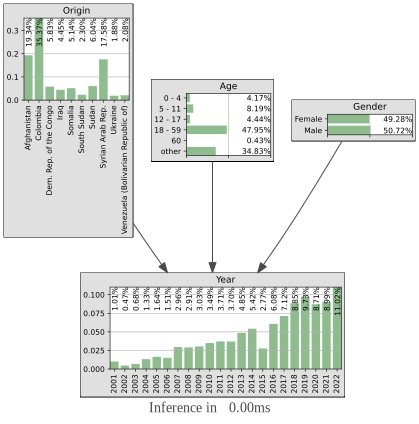

In [3]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break;
        
df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))
yearLabel = [str(i+2001) for i in range(22)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Age','Year')
model.addArc('Gender','Year')
model.addArc('Origin','Year')

df3 = df2.sum()

columns = list(df3.index)

model.cpt("Gender")[:]=[df3.loc["Female total"], df3.loc["Male total"]]
model.cpt("Age")[:] = [df3.loc["Female "+lbl] + df3.loc["Male "+lbl] for lbl in ageLabel]
model.cpt("Origin")[:]= [df2.loc[lbl, "Total"] for lbl in countryLabel]

for cLabel in countryLabel:
    temp_df = df[df["Country of origin"]==cLabel]
    for gLabel in genderLabel:
        for aLabel in ageLabel:
            temp_dictionary = {"Age":aLabel, "Gender":gLabel,"Origin":cLabel}
            temp =  temp_df.loc[:, ["Year", gLabel+" " +aLabel]]
            
            if len(temp) <22:
                for year in range(2001,2023):
                    if (temp["Year"]==year).any() == False:
                        temp.loc[len(temp)]={'Year': year, gLabel+" " +aLabel: 0}
                     
                temp = temp.sort_values("Year")
                
            temp = temp.iloc[:,1]
            temp = np.array(temp)
            model.cpt("Year")[temp_dictionary]=temp

top_model = model
gnb.showInference(top_model, evs={},size="10")

# Year as Parent

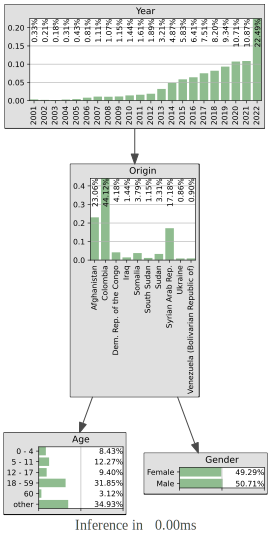

In [5]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))
yearLabel = [str(i+2001) for i in range(22)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Gender')

df2 = df.groupby("Year").sum()
model.cpt("Year")[:] = [value for value in df2.loc[:,"Total"]]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Gender")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in genderLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

gnb.showInference(model, evs={},size="10")    

In [6]:
gnb.sideBySide(gnb.getInference(top_model, evs={"Year":"2015","Age":"0 - 4","Gender":"Male"},size="10"),
               gnb.getInference(model, evs={"Year":"2015","Age":"0 - 4","Gender":"Male"},size="10"))



In [7]:
gnb.sideBySide(gnb.getInference(top_model, evs={},size="10"),
               gnb.getInference(model, evs={},size="10"))

In [10]:
model = gum.BayesNet()

df = pd.read_csv("demographics.csv")

df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:10]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])

countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

df = df[df["Country of origin"].isin(countryLabel)]
df = df.sort_values(by = [ "Country of origin", "Year"])

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

genderLabel = ["Female", "Male"]

model.add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model.add(gum.LabelizedVariable('Age','Age',ageLabel))
model.add(gum.LabelizedVariable('Gender','Gender',genderLabel))
yearLabel = [str(i+2001) for i in range(22)]

model.add(gum.LabelizedVariable('Year','Year',yearLabel)) 

model.addArc('Year','Origin')
model.addArc('Origin','Age')
model.addArc('Origin','Gender')

nodeList = ["Economic",
            "Sponsor",
            "Refugee",
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

#model.addArc('Economic','Total')
#model.addArc('Sponsor','Total')
#model.addArc('Refugee','Total')
model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model.addArc('Year','Province')
model.addArc('Origin','Province')

model

(pyAgrum.BayesNet<double>@0000024339E4FAD0) BN{nodes: 8, arcs: 8, domainSize: 10^10.1418, dim: 4929, mem: 40Ko 816o}

In [11]:
#populate gender/origin/age/year

df2 = df.groupby("Year").sum()
model.cpt("Year")[:] = [value for value in df2.loc[:,"Total"]]

year_data = []
for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for cLabel in countryLabel:
        temp_df = df[(df["Country of origin"]==cLabel) & (df["Year"]==int(year))]
        
        if len(temp_df) == 0:
            temp = 0
        else:
            temp = temp_df.iloc[0]["Total"]
            
        origin_data.append(temp)
    
    year_data.append(np.sum(origin_data))
    model.cpt("Origin")[year_dictionary] = origin_data
    
df3 = df.groupby("Country of origin").sum()
female = np.array(df3.iloc[:]["Female total"])
male = fem = np.array(df3.iloc[:]["Male total"])

model.cpt("Gender")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df3.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in genderLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model.cpt("Age")[{"Origin":cLabel}] = age_data

In [66]:
model.cpt("Province")

(pyAgrum.Potential<double>@0000024339F86F80) 
             ||  Province                                                                                         |
Year  |Origin||Newfoundl|Prince Ed|Nova Scot|New Bruns|Quebec   |Ontario  |Manitoba |Saskatche|Alberta  |British C|
------|------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
2001  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2002  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2003  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2004  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2005  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2006  |Afghan|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
[...208 more line(s) ...]
2017  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2018  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2019  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2020  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2021  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |
2022  |Venezu|| 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  | 0.0005  |

In [71]:
#dataset has different names for countries

prLabel = ["Congo, Democratic Republic of the",
            "Somalia, Democratic Republic of",
            "South Sudan, Republic of",
            "Sudan, Democratic Republic of",
            "Syria",
            "Venezuela"]

totalLabel = countryLabel + prLabel

to_canada_df = pd.read_csv("originCountry.csv").iloc[:,1:]
to_canada_df = to_canada_df[to_canada_df["Country"].isin(totalLabel)]
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]

    if index == 0:
        total_per_month = np.array(df[p].Total)
    else:
        total_per_month += np.array(df[p].Total)

total_pr = np.array(to_canada_df.iloc[:,1:].sum())


for index, cLabel in enumerate(to_canada_df.Country):
    temp_df = to_canada_df[to_canada_df["Country"]==cLabel]
    temp_df = temp_df.iloc[0,1:]
    
    for tIndex, tLabel in enumerate(temp_df):
        if tIndex % 12 == 0:
            province_data = np.zeros((12))
            
        for pLabel in provinceLabel:
            percent_to_province = df[pLabel].Total[tIndex]/total_per_month[tIndex]
            
            province_data.append(temp_df[tIndex]*percent_to_province)
            
        model.cpt("Province")[dictionary]=province_data    
        

In [80]:
province_data = np.zeros((12))
province_data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
to_canada_df = pd.read_csv("originCountry.csv")

model.cpt("Province").fillWith(1).normalize()


from sklearn.neighbors import KernelDensity
df = {}
pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]
    
    for d in nodeList:
        arr = np.array(df[p][d])
        
        hist = np.histogram(arr, bins[d])[0]
        pr[p][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    model.cpt("Economic")[index] = pr[p]["Economic"]
    model.cpt("Sponsor")[index] = pr[p]["Sponsor"]
    model.cpt("Refugee")[index] = pr[p]["Refugee"]
    
#model.cpt("Total").fillWithFunction("(Sponsor+Economic+Refugee)")

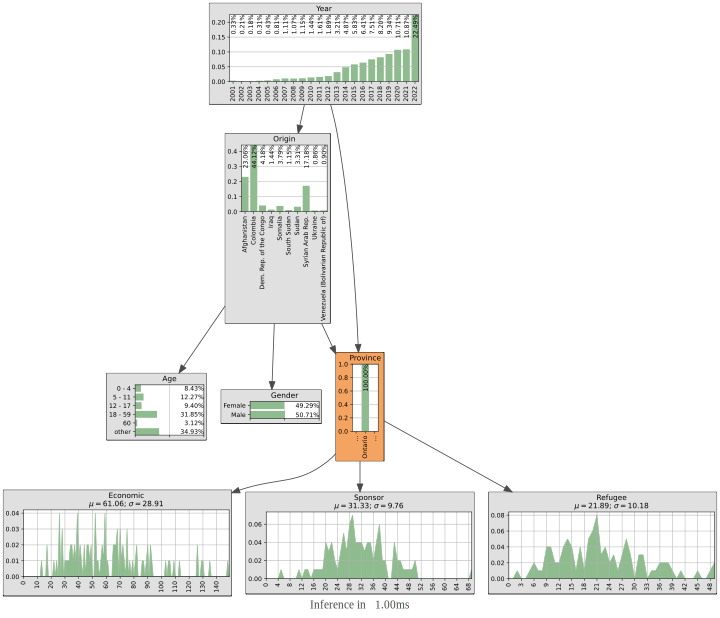

In [14]:
#model.cpt("Total").fillWithFunction("(Sponsor+Economic+Refugee)")
gnb.showInference(model, evs={"Province":"Ontario"},size="10")

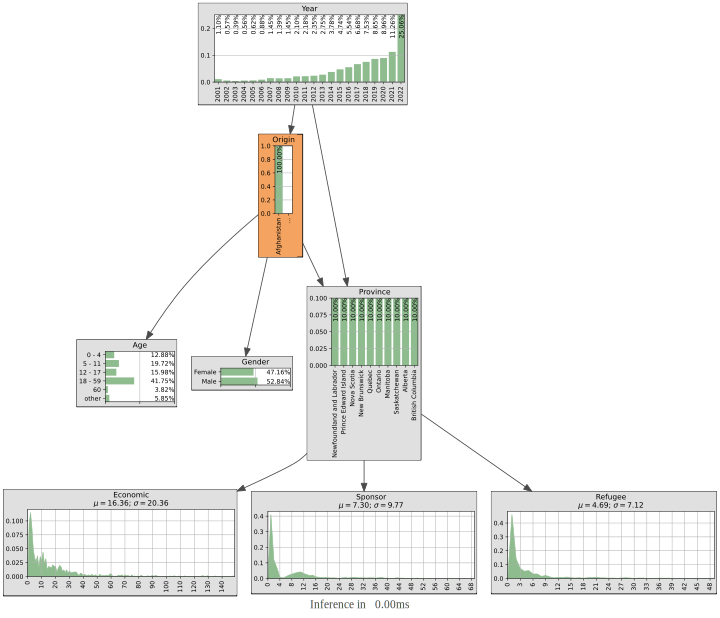

In [15]:
gnb.showInference(model, evs={"Origin":"Afghanistan"},size="10")

{'Newfoundland and Labrador':     Worker  Business  Economic  Sponsor  Refugee  Total
 0        5         0        35       15        0     50
 1       15         0        50       10       15     75
 2       10         0        35        5       35     75
 3        5         0        65       10       25     95
 4       10         0        85       10       10    105
 ..     ...       ...       ...      ...      ...    ...
 95      30         0       160       40       75    275
 96     230         0      1000       30       35   1085
 97     115         0       435       20       50    505
 98      95         0       365       25       65    455
 99      40         0       215       10       15    245
 
 [100 rows x 6 columns],
 'Prince Edward Island':     Worker  Business  Economic  Sponsor  Refugee  Total
 0        5         0        35        5        0     45
 1        0         0        55        0       10     65
 2        0         0        70        0       15     90
 3      